### Imports & Configs

In [99]:
import matplotlib.pyplot as plt
import torch
import timm
import os
import cv2
import numpy as np
import mlflow
import copy
import pandas as pd
import seaborn as sns

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchinfo import summary
from avalanche.evaluation.metrics.accuracy import Accuracy
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.models import create_model
from tqdm import tqdm
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import ListedColormap

# Custom imports
from src.model import VisionTransformerWithCustomHead
from src.data.data_handler import BrainTumorDataHandler
from src.data.brain_dataset import CustomBrainTumorDataset
from src.utils import set_seeds, log_to_mlflow

plt.style.use('seaborn-v0_8-whitegrid')


In [100]:
# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set seeds for reproducibility
set_seeds(42)

# Dataset paths
TRAIN_DIR = './src/data/train'
TEST_DIR = './src/data/test'

# Training parameters
NUM_WORKERS = min(4, os.cpu_count())
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 256
PIN_MEMORY = True

### Data Overview

In [101]:
def count_samples(directory: str):
    '''
    Count the number of samples/files in a directory.

    Args:
    -----
    directory: str
        Directory to count samples in.

    Returns:
    --------
    _ : int
        Number of samples in the directory.
    '''
    return sum(len(files) for _, _, files in os.walk(directory))


classes = os.listdir(TRAIN_DIR)
n_train = count_samples(TRAIN_DIR)
n_test = count_samples(TEST_DIR)

# Overview of the dataset
print(f'{len(classes)} Classes: {classes}')
print(f'{n_train} Training samples')
print(f'{n_test} Test samples')


4 Classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


5712 Training samples
1311 Test samples


In [102]:
def count_samples_by_class(directory: str, classes: list):
    '''
    Count the number of samples/files in a directory for each class.

    Args:
    -----
    directory: str
        Directory to count samples in.
    classes: list
        List of class names.

    Returns:
    --------
    counts : list
        List of counts for each class.
    '''
    counts = []
    for label in classes:
        path = os.path.join(directory, label)
        count = sum(len(files) for _, _, files in os.walk(path))
        counts.append(count)
    return counts

# Count samples by class
train_counts = count_samples_by_class(TRAIN_DIR, classes)
test_counts = count_samples_by_class(TEST_DIR, classes)

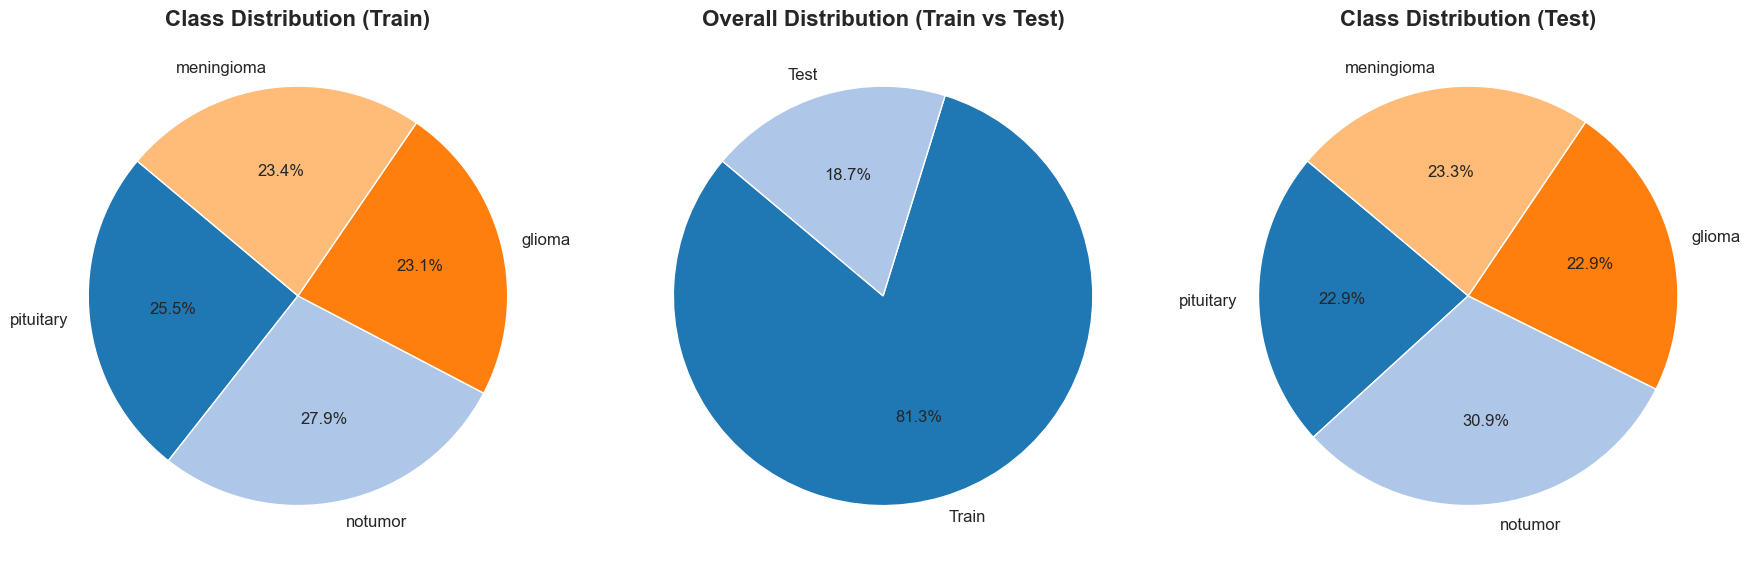

In [103]:
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 12}
autopct_font = {'fontsize': 10, 'fontweight': 'bold'}

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

colors = plt.get_cmap('tab20').colors 

# Class Distribution in Training Set 
axs[0].pie(train_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors, textprops=label_font)
axs[0].set_title('Class Distribution (Train)', fontdict=title_font)

# Overall Distribution (Train vs Test)
axs[1].pie([n_train, n_test], labels=['Train', 'Test'], autopct='%1.1f%%', startangle=140, colors=colors[:2], textprops=label_font)
axs[1].set_title('Overall Distribution (Train vs Test)', fontdict=title_font)

# Class Distribution in Test Set
axs[2].pie(test_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors, textprops=label_font)
axs[2].set_title('Class Distribution (Test)', fontdict=title_font)

plt.tight_layout()  
plt.show()

In [ ]:
def get_image_shapes(directory):
    '''
    Get the distribution of image shapes in a directory.

    Args:
    -----
    directory: str
        Directory containing the images.

    Returns:
    --------
    shape_distribution: dict
        Dictionary containing the distribution of image shapes.
    '''
    shape_distribution = {}
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    filepath = os.path.join(subdir, file)
                    with Image.open(filepath) as img:
                        shape = img.size  
                        if shape in shape_distribution:
                            shape_distribution[shape] += 1
                        else:
                            shape_distribution[shape] = 1
                except Exception as e:
                    print(f"Error opening {filepath}: {e}")

    return shape_distribution

image_sizes = get_image_shapes(TRAIN_DIR)

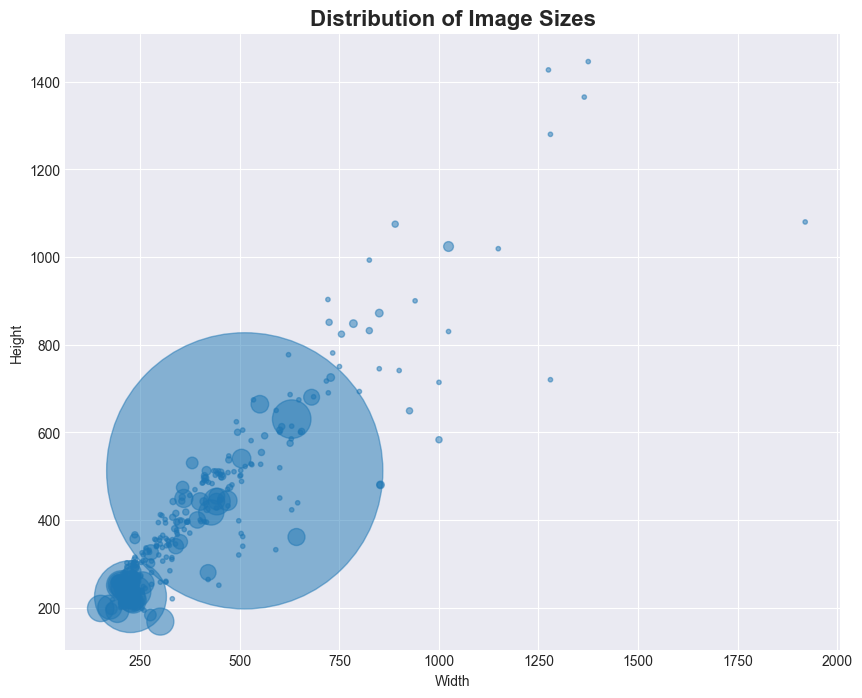

In [55]:
widths = [size[0] for size in image_sizes.keys()]
heights = [size[1] for size in image_sizes.keys()]
counts = [count for count in image_sizes.values()]

plt.figure(figsize=(10, 8))
plt.scatter(widths, heights, s=np.array(counts) * 10, alpha=0.5) 
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Sizes', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.grid(True)

plt.show()

### Data Augmentation & Normalization

In [72]:
class CustomBrainTumorDataset(datasets.ImageFolder):
    '''
    Custom dataset class for the Brain Tumor dataset.

    Attributes:
    -----------
    root: str
        Root directory of the dataset.
    transform: torchvision.transforms
        Transform to apply to the images.
    '''

    def __init__(self, root, transform=None):
        '''
        Constructor for the CustomBrainTumorDataset class.

        Args:
        -----
        root: str
            Root directory of the dataset.
        transform: torchvision.transforms
            Transform to apply to the images.
        '''
        super(CustomBrainTumorDataset, self).__init__(root, transform)

    def __getitem__(self, index):
        '''
        Get item method for the dataset class.

        Args:
        -----
        index: int
            Index of the item to retrieve.

        Returns:
        --------
        image: torch.Tensor
            Image tensor.
        target: int
            Target label.
        '''
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')

        # Check if the image needs padding
        if image.size[0] < 320 or image.size[1] < 320:
            padding = (max(320 - image.size[0], 0), max(320 - image.size[1], 0))
            padding = (padding[0]//2, padding[1]//2, padding[0] - padding[0]//2, padding[1] - padding[1]//2)
            image = transforms.functional.pad(image, padding, fill=0, padding_mode='constant')

        # Apply transform if available
        if self.transform:
            image = self.transform(image)

        return image, target

In [104]:
class CenterCropPercentage:
    '''
    Class to center crop an image by a certain percentage.

    Attributes:
    -----------
    crop_percentage: float
        Percentage to crop the image by.

    Methods:
    --------
    __call__(self, img: PIL.Image) -> PIL.Image:
        Apply the center crop to the image.
    '''

    def __init__(self, crop_percentage):
        '''
        Constructor for the CenterCropPercentage class.

        Args:
        -----
        crop_percentage: float
            Percentage to crop the image by.
        '''
        self.crop_percentage = crop_percentage

    def __call__(self, img):
        '''
        Apply the center crop to the image.

        Args:
        -----
        img: PIL.Image
            Image to crop.

        Returns:
        --------
        img_cropped: PIL.Image
            Cropped image.
        '''
        width, height = img.size
        crop_size = int(min(width, height) * self.crop_percentage / 100)

        # Calculate the top, left position of the crop
        left = (width - crop_size) // 2
        top = (height - crop_size) // 2

        img_cropped = TF.crop(img, top, left, crop_size, crop_size)
        
        return img_cropped

In [78]:
# Data Augmentation and Normalization 
CROP_PERCENTAGE = 80
CROP_SIZE = (320, 320)
RESIZE_SIZE = (224, 224)
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]

# Training/Validation set transformations
train_transforms = transforms.Compose([
            #transforms.CenterCrop(CROP_SIZE),
            CenterCropPercentage(CROP_PERCENTAGE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  

# Test set transformations
test_transforms = transforms.Compose([
            #transforms.CenterCrop(CROP_SIZE),
            CenterCropPercentage(CROP_PERCENTAGE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  


# Create datasets from directories
#train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
#test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_data = CustomBrainTumorDataset(TRAIN_DIR, transform=train_transforms)
test_data = CustomBrainTumorDataset(TEST_DIR, transform=test_transforms)

CLASSES = train_data.classes
N_CLASSES = len(CLASSES)
CLASS_INDICES = train_data.class_to_idx
INDICES_CLASS = {v: k for k, v in CLASS_INDICES.items()}

In [79]:
# Initialize the BrainTumorData class
brain_data = BrainTumorDataHandler(train_data, test_data, TRAIN_VAL_SPLIT, BATCH_SIZE, NUM_WORKERS, PIN_MEMORY)

# Get the data loaders for training, validation and testing
train_loader, val_loader, test_loader = brain_data.get_loaders()

### Model initialization

In [43]:
# Pretrained model name from timm
MODEL_NAME = 'vit_base_patch16_224'

# Instantiate the custom model
custom_vit = VisionTransformerWithCustomHead(MODEL_NAME, N_CLASSES)

In [45]:
summary(model=custom_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        )

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformerWithCustomHead               [32, 3, 224, 224]    [32, 4]              --                   Partial
├─VisionTransformer: 1-1                      [32, 3, 224, 224]    [32, 768]            152,064              False
│    └─PatchEmbed: 2-1                        [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    │    └─Conv2d: 3-1                       [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    │    └─Identity: 3-2                     [32, 196, 768]       [32, 196, 768]       --                   --
│    └─Dropout: 2-2                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Identity: 2-3                          [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Identity: 2-4                          [32, 197, 768]       [32, 197, 768]  

### Model Training

In [12]:
def train(model, train_loader, val_loader, opt, scheduler, lr, batch_size, epoch=10):
    '''
    Trains and evaluates the model on the train and validation set with specified optimizer and scheduler. For
    each epoch, the model accuracy and loss is logged to MLFlow together with the learning rate and batch size.

    Args:
    -----
    model: nn.Module
        The model to be trained
    train_loader: DataLoader
        The DataLoader containing the training data
    val_loader: DataLoader
        The DataLoader containing the validation data
    opt: torch.optim.Optimizer
        The optimizer to be used for training
    scheduler: torch.optim.lr_scheduler
        The learning rate scheduler to be used
    lr: float
        The learning rate
    batch_size: int
        The batch size  
    '''

    for ep in tqdm(range(epoch)):
        model.train()
        train_acc = Accuracy()
        total_loss = 0
        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)
            out = model(feature)
            loss = F.cross_entropy(out, label)
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_acc.update(out.argmax(dim=1).view(-1), label)
            total_loss += loss.item()

        scheduler.step(ep)

        train_acc = train_acc.result()
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = test(model, val_loader)

        log_to_mlflow(model, train_acc, train_loss, val_acc, val_loss, ep, lr, batch_size)

    return train_acc, val_acc


@torch.no_grad()
def test(model, loader):
    '''
    Validates the model on the given data loader and returns the accuracy and average loss.

    Args:
    -----
    model: nn.Module
        The model to be evaluated
    loader: DataLoader
        The DataLoader containing the validation data

    Returns:
    --------
    acc: float
        The validation accuracy of the model
    avg_loss: float
        The average validation loss of the model
    '''
    model.eval()
    acc = Accuracy()
    total_loss = 0

    for feature, label in loader:  
        feature, label = feature.to(device), label.to(device)
        out = model(feature)
        acc.update(out.argmax(dim=1).view(-1), label)
        loss = F.cross_entropy(out, label)
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    return acc.result(), avg_loss

In [13]:
# Hyperparameters to use for training
params = {
    'learning_rate': np.logspace(-4, -2, 3)
    # Further hyperparameters can be inserted here
}


# Training loop
for lr in params['learning_rate']:
    with mlflow.start_run():
        
        model = copy.deepcopy(custom_vit)
        model.to(device)

        optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr, weight_decay=0.001)
        
        scheduler = CosineLRScheduler(optimizer, t_initial=100,
                                  warmup_t=10, lr_min=1e-5, warmup_lr_init=1e-6)

        train_acc, train_loss = train(model, train_loader, val_loader, optimizer, scheduler, lr, BATCH_SIZE)

  0%|          | 0/10 [00:00<?, ?it/s]Successfully registered model 'brain-tumor-model-0-0.0001'.
Created version '1' of model 'brain-tumor-model-0-0.0001'.
 10%|█         | 1/10 [28:56<4:20:28, 1736.45s/it]Successfully registered model 'brain-tumor-model-1-0.0001'.
Created version '1' of model 'brain-tumor-model-1-0.0001'.
 20%|██        | 2/10 [55:57<3:42:29, 1668.73s/it]Successfully registered model 'brain-tumor-model-2-0.0001'.
Created version '1' of model 'brain-tumor-model-2-0.0001'.
 30%|███       | 3/10 [1:23:35<3:14:05, 1663.63s/it]Successfully registered model 'brain-tumor-model-3-0.0001'.
Created version '1' of model 'brain-tumor-model-3-0.0001'.
 40%|████      | 4/10 [1:51:31<2:46:51, 1668.55s/it]Successfully registered model 'brain-tumor-model-4-0.0001'.
Created version '1' of model 'brain-tumor-model-4-0.0001'.
 50%|█████     | 5/10 [2:19:19<2:19:02, 1668.50s/it]Successfully registered model 'brain-tumor-model-5-0.0001'.
Created version '1' of model 'brain-tumor-model-5-0

### Testing & Evaluation

In [22]:
# Load the best model
model_name = "brain-tumor-model-9-0.0001"
model_version = 1

best_model = mlflow.pytorch.load_model(model_uri=f'models:/{model_name}/{model_version}')

In [55]:
# Dictionary to store the correct predictions for each class
correct_pred = {classname: 0 for classname in CLASSES}
total_pred = {classname: 0 for classname in CLASSES}

# Lists to store all labels and predictions
all_labels = []
all_predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        # Count the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print out the classification report for each class
target_names = list(CLASSES)
classification_report_str = classification_report(all_labels, all_predictions, target_names=CLASSES)

# Output the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy for class: glioma is 97.3 %
Accuracy for class: meningioma is 88.7 %
Accuracy for class: notumor is 50.3 %
Accuracy for class: pituitary is 74.3 %
Confusion Matrix:
[[223  49   0  28]
 [ 27 154  74  51]
 [  3   4 394   4]
 [ 17  13   4 266]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.83      0.74      0.78       300
  meningioma       0.70      0.50      0.59       306
     notumor       0.83      0.97      0.90       405
   pituitary       0.76      0.89      0.82       300

    accuracy                           0.79      1311
   macro avg       0.78      0.78      0.77      1311
weighted avg       0.78      0.79      0.78      1311



NameError: name 'conf_matrix' is not defined

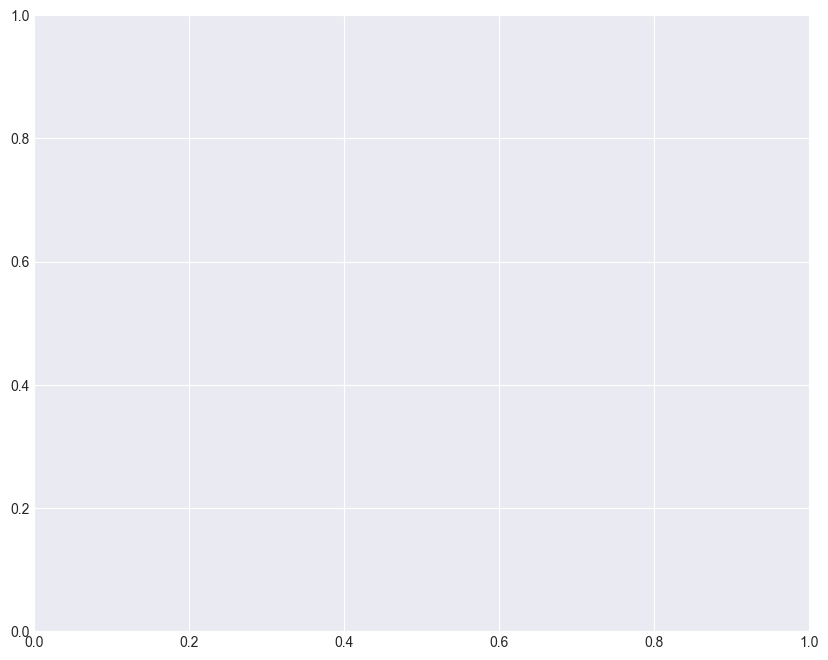

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_theme(font_scale=1.5)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}, fmt='d', cmap='Blues', cbar=False, square=True)

# Adding labels, title, and axis ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax.xaxis.set_ticklabels(['glioma', 'meningioma', 'notumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma', 'notumor', 'pituitary'])

plt.tight_layout()
plt.show()

### Visualizations

(224, 224, 3)


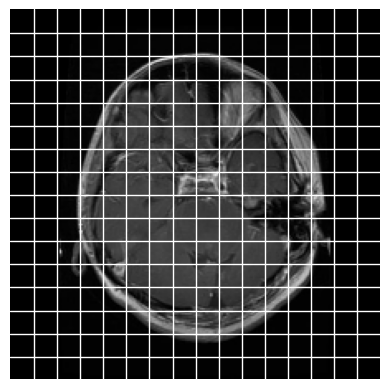

In [61]:
img = cv2.imread('./src/data/test/glioma/Te-gl_0010.jpg')
img = cv2.resize(img, (224,224))
print(img.shape)

# Parameters
tiles_per_dim = 16 
img_height, img_width, _ = img.shape
tile_height = img_height // tiles_per_dim
tile_width = img_width // tiles_per_dim

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray') 

# Add white grid lines
for i in range(1, tiles_per_dim):
    ax.axhline(y=i * tile_height, color='white', linewidth=1)
    ax.axvline(x=i * tile_width, color='white', linewidth=1)

ax.set_axis_off()  
plt.show()


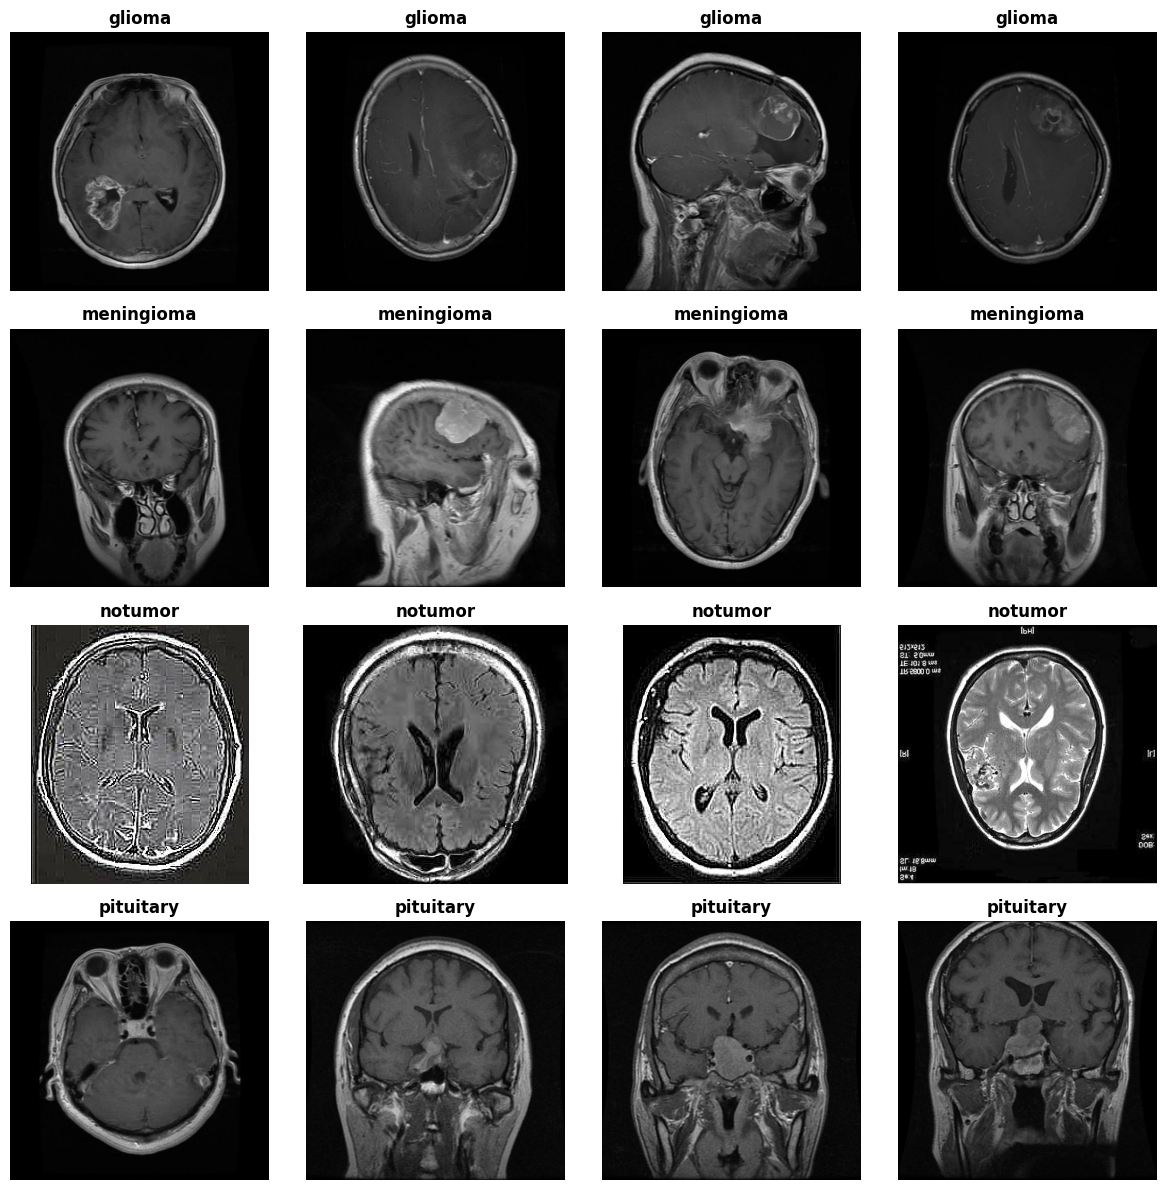

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) 
axes = axes.ravel()

index = 0
for class_name in CLASSES:
    folder_path = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(folder_path)[:4] 

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)
        img_data = np.array(img, dtype=np.uint8)  
        axes[index].imshow(img_data, cmap='gray')  
        axes[index].set_title(f'{class_name}', fontweight='bold')
        axes[index].axis('off')
        index += 1

plt.tight_layout()
plt.show()

In [89]:
import torchvision.transforms.functional as TF
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class CenterCropPercentage:
    def __init__(self, crop_percentage):
        self.crop_percentage = crop_percentage

    def __call__(self, img):
        # Calculate the crop size based on the input percentage
        width, height = img.size
        crop_size = int(min(width, height) * self.crop_percentage / 100)

        # Calculate the top, left position of the crop
        left = (width - crop_size) // 2
        top = (height - crop_size) // 2

        # Crop the image
        img_cropped = TF.crop(img, top, left, crop_size, crop_size)
        return img_cropped

(512, 512)


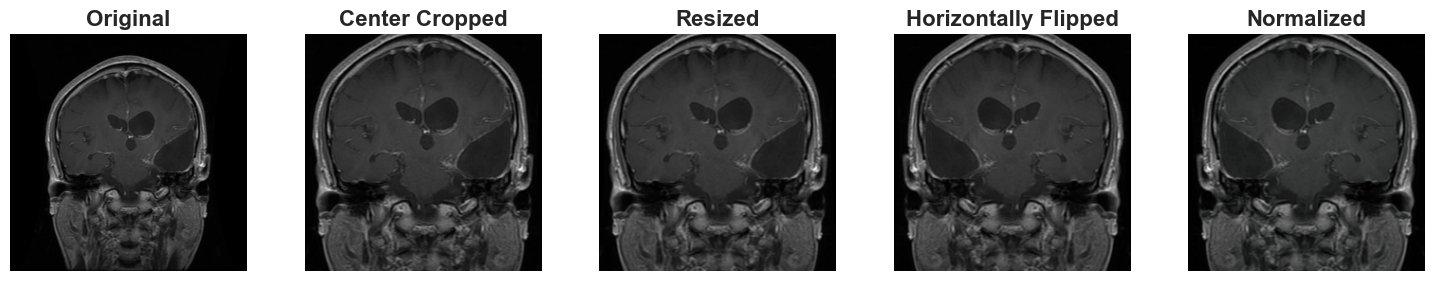

In [92]:
# AUgmentation process
# Data Augmentation and Normalization 
CROP_SIZE = (320, 320)
RESIZE_SIZE = (224, 224)
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]

#center_crop = transforms.CenterCrop(CROP_SIZE)
center_crop = CenterCropPercentage(CROP_PERCENTAGE)
resize = transforms.Resize(RESIZE_SIZE, interpolation=Image.BICUBIC)  
random_flip = transforms.RandomHorizontalFlip(p=1)  
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)

img_path = './src/data/train/glioma/Tr-gl_0012.jpg'
img = Image.open(img_path)
print(img.size)

# Apply transformations
img_center_cropped = center_crop(img)
img_resized = resize(img_center_cropped)
img_flipped = random_flip(img_resized)
img_tensor = to_tensor(img_flipped)
img_normalized = normalize(img_tensor)

# Convert normalized image back to displayable form
img_normalized_disp = img_normalized.clone()
for i in range(3):
    img_normalized_disp[i] = img_normalized_disp[i] * STD_IMAGENET[i] + MEAN_IMAGENET[i]
img_normalized_disp = transforms.ToPILImage()(img_normalized_disp)

title_font = {'fontsize': 16, 'fontweight': 'bold'}
# Plotting
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].imshow(img)
ax[0].set_title("Original", fontdict=title_font)
ax[0].axis('off')

ax[1].imshow(img_center_cropped)
ax[1].set_title("Center Cropped", fontdict=title_font)
ax[1].axis('off')

ax[2].imshow(img_resized)
ax[2].set_title("Resized", fontdict=title_font)
ax[2].axis('off')

ax[3].imshow(img_flipped)
ax[3].set_title("Horizontally Flipped", fontdict=title_font)
ax[3].axis('off')

ax[4].imshow(img_normalized_disp)
ax[4].set_title("Normalized", fontdict=title_font)
ax[4].axis('off')

plt.tight_layout()
plt.show()

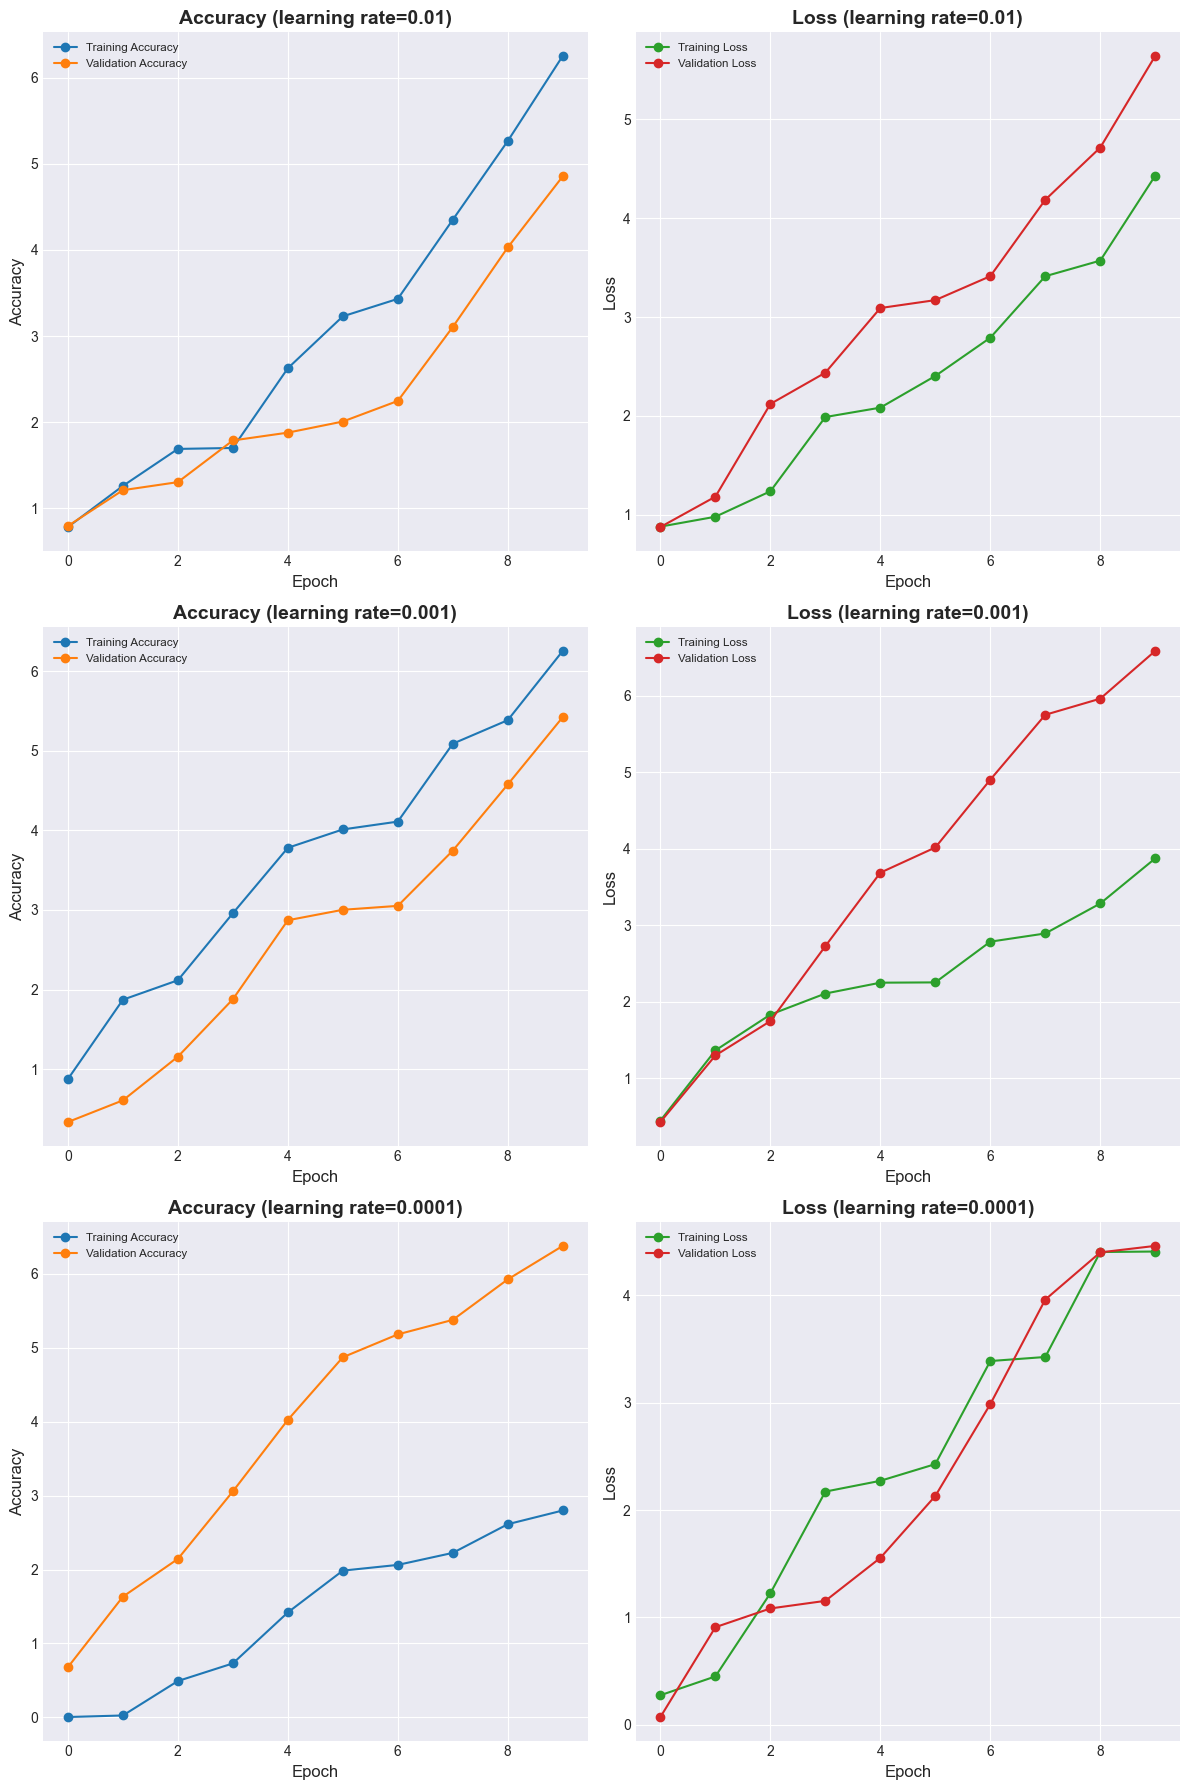

In [14]:

colors = {
    'train_acc': '#1f77b4',  
    'val_acc': '#ff7f0e',   
    'train_loss': '#2ca02c',  
    'val_loss': '#d62728'  
}

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

title_font = {'fontsize': 14, 'fontweight': 'bold'}
label_font = {'fontsize': 12}
# Simulate data for training and validation accuracy and loss
learning_rates = [0.01, 0.001, 0.0001]
epochs = range(10)
training_accuracies = [np.random.rand(10).cumsum() for _ in learning_rates]
validation_accuracies = [np.random.rand(10).cumsum() for _ in learning_rates]
training_losses = [np.random.rand(10).cumsum() for _ in learning_rates]
validation_losses = [np.random.rand(10).cumsum() for _ in learning_rates]

# Plotting
for i, lr in enumerate(learning_rates):
    # Plot training and validation accuracy
    axs[i, 0].plot(epochs, training_accuracies[i], label='Training Accuracy', color=colors['train_acc'], marker='o')
    axs[i, 0].plot(epochs, validation_accuracies[i], label='Validation Accuracy', color=colors['val_acc'], marker='o')
    axs[i, 0].set_title(f'Accuracy (learning rate={lr})', fontdict=title_font)
    axs[i, 0].set_xlabel('Epoch', fontdict=label_font)
    axs[i, 0].set_ylabel('Accuracy', fontdict=label_font)
    axs[i, 0].legend(loc='upper left', fontsize='small')

    # Plot training and validation loss
    axs[i, 1].plot(epochs, training_losses[i], label='Training Loss', color=colors['train_loss'], marker='o')
    axs[i, 1].plot(epochs, validation_losses[i], label='Validation Loss', color=colors['val_loss'], marker='o')
    axs[i, 1].set_title(f'Loss (learning rate={lr})', fontdict=title_font)
    axs[i, 1].set_xlabel('Epoch', fontdict=label_font)
    axs[i, 1].set_ylabel('Loss', fontdict=label_font)
    axs[i, 1].legend(loc='upper left', fontsize='small')

# Adjust layout and display plot
plt.tight_layout()
plt.show()



In [10]:
#t-SNE for all labels
df = pd.DataFrame()
model = timm.create_model('vit_base_patch16_224', pretrained=True, drop_path_rate=0.1, num_classes=0)

model.eval()

for data, targets in test_loader:  

    embeddings = model(data) 
    

    temp_df = pd.DataFrame(embeddings.detach().cpu().numpy())
    temp_df['label'] = targets.numpy() 

    df = pd.concat([df, temp_df], ignore_index=True)

features = df.drop('label', axis=1).values  # Get the numerical values
labels = df['label'].values

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1311 samples in 0.001s...
[t-SNE] Computed neighbors for 1311 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1311
[t-SNE] Computed conditional probabilities for sample 1311 / 1311
[t-SNE] Mean sigma: 0.628570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.989883
[t-SNE] KL divergence after 300 iterations: 1.204704


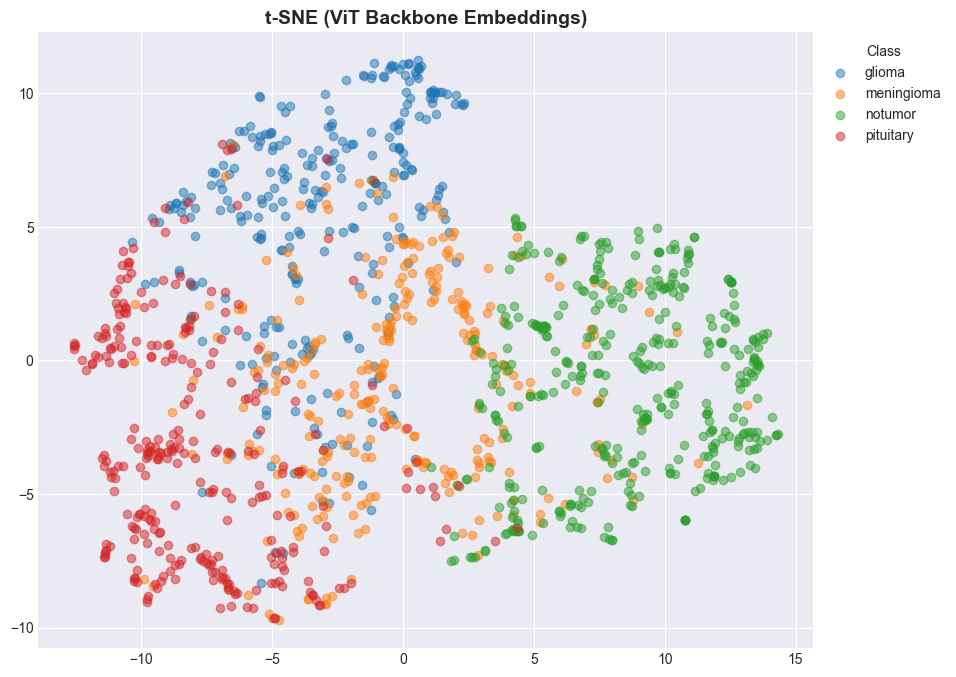

In [52]:
from matplotlib.colors import ListedColormap


tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(features)

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']   # One color for each label
cmap = ListedColormap(colors)
labels = df['label'].values
unique_labels = np.unique(labels)

# Plotting each class separately to create plot handles for the legend
plt.figure(figsize=(10, 8))

# Creating scatter plots for each unique label
for i, label in enumerate(unique_labels):
    plt.scatter(df.loc[df['label'] == label, 'tsne-2d-one'], 
                df.loc[df['label'] == label, 'tsne-2d-two'],
                color=cmap(i),  # Map the color using the colormap
                label=INDICES_CLASS[label],  # Use the actual class names for the legend
                alpha=0.5)

# Adding the legend outside the plot
plt.legend(title='Class', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust location as needed
plt.title('t-SNE (ViT Backbone Embeddings)', fontdict=title_font)
#plt.xlabel('t-SNE 2D One')
#plt.ylabel('t-SNE 2D Two')
#plt.axis('off')  # Turn off the axis
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1311 samples in 0.007s...
[t-SNE] Computed neighbors for 1311 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1311
[t-SNE] Computed conditional probabilities for sample 1311 / 1311
[t-SNE] Mean sigma: 0.628570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.990726
[t-SNE] KL divergence after 300 iterations: 1.204381


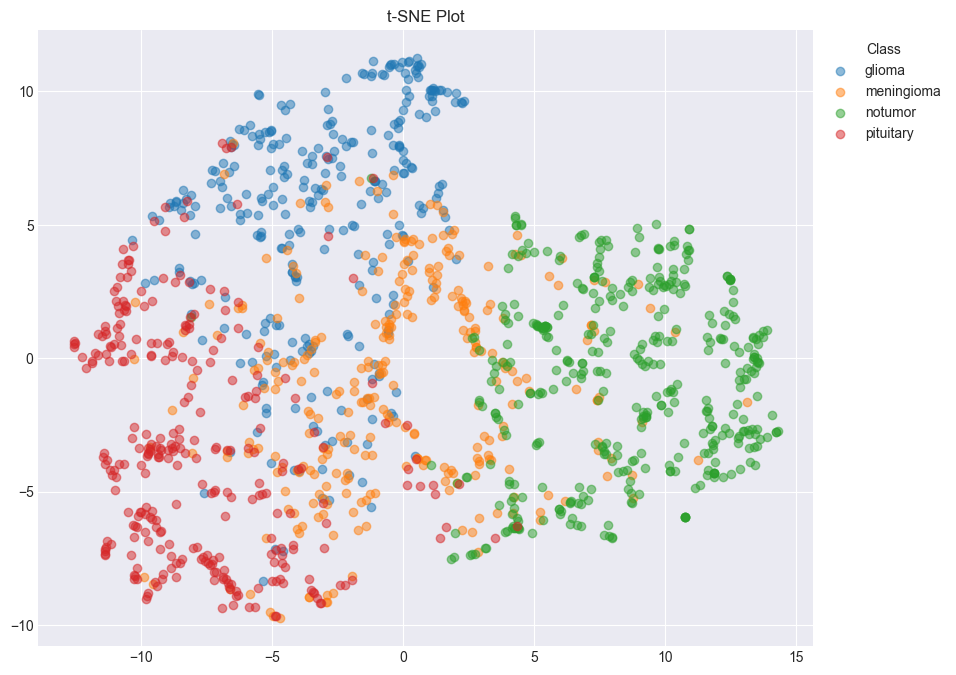

In [23]:
df2 = pd.DataFrame()

best_model.eval()

for data, targets in test_loader:  

    embeddings = best_model(data) 
    
    temp_df = pd.DataFrame(embeddings.detach().cpu().numpy())
    temp_df['label'] = targets.numpy() 

    df2 = pd.concat([df2, temp_df], ignore_index=True)

features = df2.drop('label', axis=1).values  # Get the numerical values
labels = df2['label'].values

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(features)

df2['tsne-2d-one'] = tsne_results[:,0]
df2['tsne-2d-two'] = tsne_results[:,1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']   # One color for each label
cmap = ListedColormap(colors)
labels = df2['label'].values
unique_labels = np.unique(labels)

# Plotting each class separately to create plot handles for the legend
plt.figure(figsize=(10, 8))

# Creating scatter plots for each unique label
for i, label in enumerate(unique_labels):
    plt.scatter(df.loc[df2['label'] == label, 'tsne-2d-one'], 
                df.loc[df2['label'] == label, 'tsne-2d-two'],
                color=cmap(i),  # Map the color using the colormap
                label=INDICES_CLASS[label],  # Use the actual class names for the legend
                alpha=0.5)

# Adding the legend outside the plot
plt.legend(title='Class', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust location as needed
plt.title("t-SNE (ViT Backbone + Custom MLP Head Embeddings)")
#plt.xlabel('t-SNE 2D One')
#plt.ylabel('t-SNE 2D Two')
plt.show()

In [85]:
# Code by https://github.com/huggingface/pytorch-image-models/discussions/1232
def to_tensor(img):
    transform_fn = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

# img = Image.open('./src/data/test/glioma/Te-gl_0010.jpg')
# x = to_tensor(img)

# model = create_model('vit_base_patch16_224', pretrained=True)
# model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

# y = model(x.unsqueeze(0))
# attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
# cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

# img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
# cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

# show_img(img)
# show_img(attn_map)
# show_img(cls_weight)
# show_img(img_resized)
# show_img2(img_resized, cls_resized, alpha=0.6)

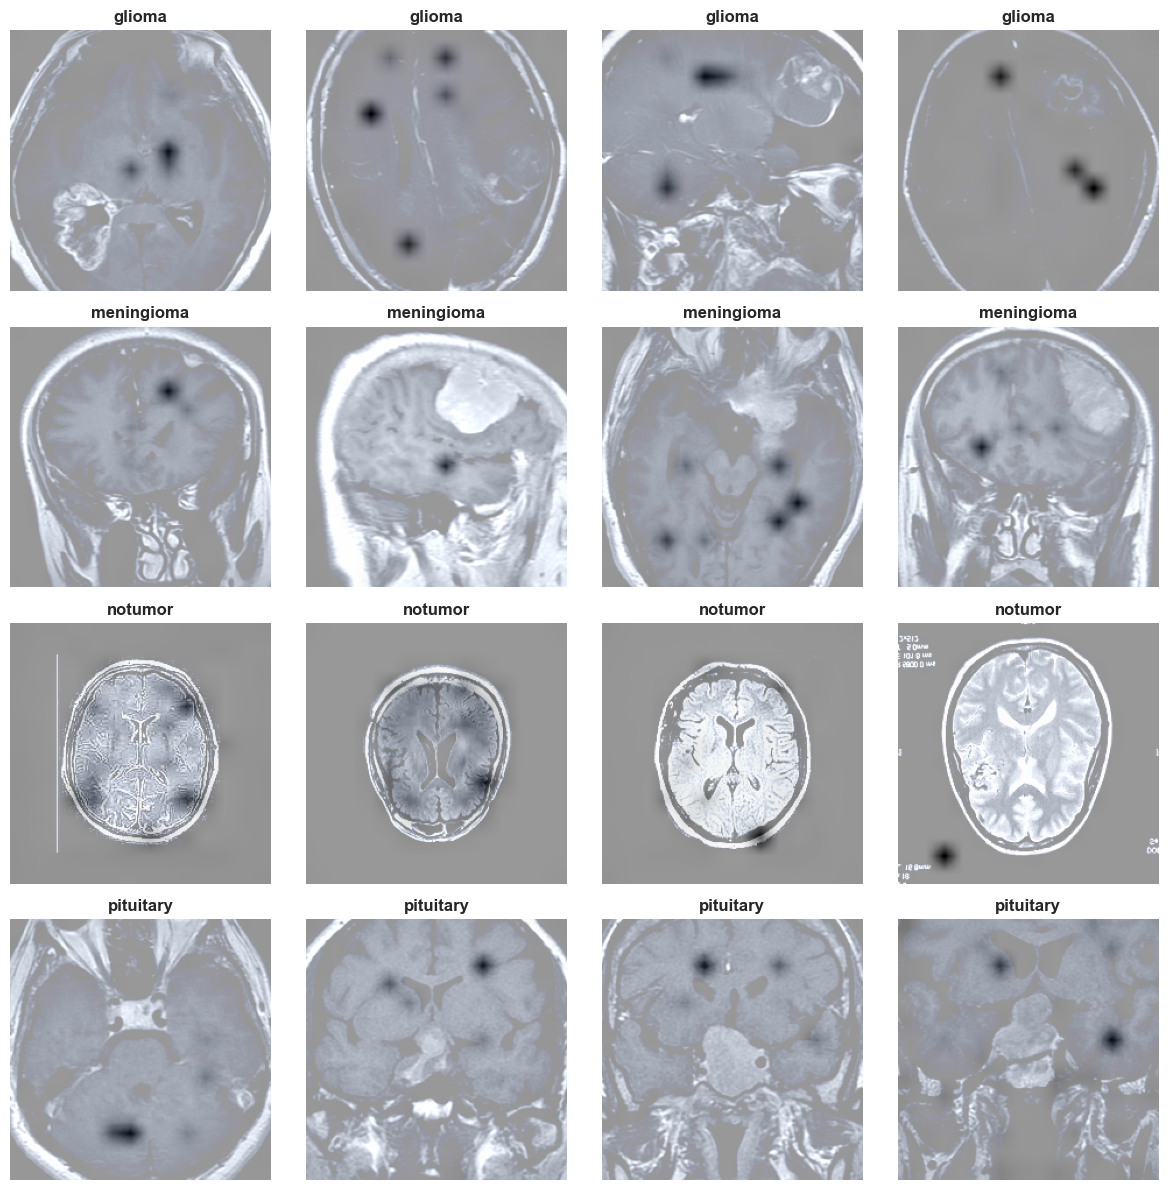

In [86]:
def show_img2(ax, img1, img2, alpha=0.8):
    # img1 and img2 should be numpy arrays or PyTorch tensors
    if isinstance(img1, torch.Tensor):
        img1 = img1.numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.numpy()

    ax.imshow(img1)
    ax.imshow(img2, alpha=alpha)  # img2 is expected to have the same dimensions or be broadcastable
    ax.axis('off')

model = create_model('vit_base_patch16_224', pretrained=True)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) 
axes = axes.ravel()

index = 0
for class_name in CLASSES:
    folder_path = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(folder_path)[:4] 

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)

        img = Image.open(image_path, mode='r').convert('RGB')
        x = to_tensor(img)

        model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

        y = model(x.unsqueeze(0))
        attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
        cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

        img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        show_img2(axes[index], img_resized, cls_resized, alpha=0.6)
        axes[index].set_title(f'{class_name}', fontweight='bold')
        axes[index].axis('off')
        index += 1

plt.tight_layout()
plt.show()